In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from scipy import stats as sps
from scipy.interpolate import interp1d

from IPython.display import clear_output

In [2]:
import copy, math

In [3]:
import plotly.express as px

In [4]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [5]:
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
#import plotly.graph_objects as go
init_notebook_mode(connected=True)

In [6]:
def format_comma(num):
    return f'{num:,.0f}'

# Setup

## Define all keys

In [7]:
state_key = {
'EC':'Eastern Cape',
'FS':'Free State',
'GP':'Gauteng',
'KZN':'Kwazulu Natal',
'LP':'Limpopo',
'MP':'Mpumalanga',
'NC':'Northern Cape',
'NW':'North-West',
'WC':'Western Cape'
}
state_filter = list(state_key.keys())
state_filter

['EC', 'FS', 'GP', 'KZN', 'LP', 'MP', 'NC', 'NW', 'WC']

In [8]:
state_labels = list(state_key.values())
state_labels

['Eastern Cape',
 'Free State',
 'Gauteng',
 'Kwazulu Natal',
 'Limpopo',
 'Mpumalanga',
 'Northern Cape',
 'North-West',
 'Western Cape']

In [9]:
#not required
state_filter_d = copy.deepcopy(state_filter)
state_filter_d.append('Date')
state_filter_d

['EC', 'FS', 'GP', 'KZN', 'LP', 'MP', 'NC', 'NW', 'WC', 'Date']

In [10]:
state_filter_t = copy.deepcopy(state_filter)
state_filter_t.insert(0,'Total RSA')
state_filter_t

['Total RSA', 'EC', 'FS', 'GP', 'KZN', 'LP', 'MP', 'NC', 'NW', 'WC']

In [11]:
state_filter_all = copy.deepcopy(state_filter)
state_filter_all.insert(0,'Total RSA')
state_filter_all.append('Date')
state_filter_all

['Total RSA', 'EC', 'FS', 'GP', 'KZN', 'LP', 'MP', 'NC', 'NW', 'WC', 'Date']

## Download SA population stats

In [12]:
# Mid-year 2019 Estimates
# https://www.statssa.gov.za/publications/P0302/P03022019.pdf
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/district_data/za_province_pop.csv'
province_pops = pd.read_csv(url, header=None, names=['Province','Pop'])
province_pops

Province       Pop
0        Gauteng  15176115
1  KwaZulu-Natal  11289086
2   Western Cape   6844272
3   Eastern Cape   6712276
4        Limpopo   5982584
5     Mpumalanga   4592187
6      Northwest   4027160
7     Free State   2887465
8  Northern Cape   1263875

In [13]:
country_pop = province_pops['Pop'].sum()
country_pop

58775020

In [14]:
province_pops.iloc[0]['Pop']

15176115

In [15]:
state_pop = {
    'EC': 6712276,
    'FS': 2887465,
    'GP': 15176115,
    'KZN': 11289086,
    'LP': 5982584,
    'MP': 4592187,
    'NC': 1263875,
    'NW': 4027160,
    'WC': 6844272
}

# SQL Import Test

In [16]:
import sqlite3

con = sqlite3.connect("../db.sqlite3")

df = pd.read_sql_query('SELECT * FROM dashboard_coviddata', con)
df

id        Date Var       EC      FS      GP     KZN     LP     MP  \
0     1295  2020-03-05   C      0.0     0.0     0.0     1.0    0.0    0.0   
1     1296  2020-03-07   C      0.0     0.0     1.0     1.0    0.0    0.0   
2     1297  2020-03-08   C      0.0     0.0     1.0     2.0    0.0    0.0   
3     1298  2020-03-09   C      0.0     0.0     1.0     6.0    0.0    0.0   
4     1299  2020-03-11   C      0.0     0.0     5.0     7.0    0.0    0.0   
...    ...         ...  ..      ...     ...     ...     ...    ...    ...   
1369  3205  2020-12-01   A   9407.0  5931.0  1138.0  6485.0  332.0  346.0   
1370  3206  2020-12-02   A  10144.0  5973.0  1605.0  6975.0  394.0  405.0   
1371  3207  2020-11-30   T      NaN     NaN     NaN     NaN    NaN    NaN   
1372  3208  2020-12-01   T      NaN     NaN     NaN     NaN    NaN    NaN   
1373  3209  2020-12-02   T      NaN     NaN     NaN     NaN    NaN    NaN   

          NC     NW  Unknown    Total  \
0        0.0    0.0      0.0        1   
1        0.0    0.0      0.0        2   
2        0.0    0.0      0.0        3   
3        0.0    0.0      0.0        7   
4        0.0    0.0      0.0       13   
...      ...    ...      ...      ...   
1369  2216.0  990.0      0.0    38124   
1370  2217.0  714.0      0.0    40458   
1371     NaN    NaN      NaN  5383078   
1372     NaN    NaN      NaN  5383078   
1373     NaN    NaN      NaN  5383078   

                                                 Source       WC  
0                                                   0.0      0.0  
1                                                   0.0      0.0  
2                                                   0.0      0.0  
3                                                   0.0      0.0  
4                                                   0.0      1.0  
...                                                 ...      ...  
1369                                                     11279.0  
1370                                                     12031.0  
1371  https://www.nicd.ac.za/latest-confirmed-cases-...      NaN  
1372  https://www.nicd.ac.za/latest-confirmed-cases-...      NaN  
1373  https://www.nicd.ac.za/latest-confirmed-cases-...      NaN  

[1374 rows x 15 columns]

# Download Data

## Download case data

In [17]:
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_confirmed.csv'
states_cases_i = pd.read_csv(url, parse_dates=['date'], dayfirst=True, squeeze=True, index_col=0)
states_cases_i

YYYYMMDD        EC       FS        GP       KZN       LP       MP  \
date                                                                            
2020-03-05  20200305       0.0      0.0       0.0       1.0      0.0      0.0   
2020-03-07  20200307       0.0      0.0       1.0       1.0      0.0      0.0   
2020-03-08  20200308       0.0      0.0       1.0       2.0      0.0      0.0   
2020-03-09  20200309       0.0      0.0       1.0       6.0      0.0      0.0   
2020-03-11  20200311       0.0      0.0       5.0       7.0      0.0      0.0   
...              ...       ...      ...       ...       ...      ...      ...   
2020-11-28  20201128  125480.0  58983.0  234572.0  127506.0  18550.0  31317.0   
2020-11-29  20201129  126520.0  59014.0  234831.0  127670.0  18573.0  31360.0   
2020-11-30  20201130  127737.0  59030.0  234957.0  127842.0  18584.0  31375.0   
2020-12-01  20201201  128889.0  59058.0  235193.0  128152.0  18624.0  31434.0   
2020-12-02  20201202  130430.0  59115.0  235664.0  128697.0  18689.0  31493.0   

                 NC       NW        WC  UNKNOWN   total  \
date                                                      
2020-03-05      0.0      0.0       0.0      0.0       1   
2020-03-07      0.0      0.0       0.0      0.0       2   
2020-03-08      0.0      0.0       0.0      0.0       3   
2020-03-09      0.0      0.0       0.0      0.0       7   
2020-03-11      0.0      0.0       1.0      0.0      13   
...             ...      ...       ...      ...     ...   
2020-11-28  23156.0  34793.0  130782.0      0.0  785139   
2020-11-29  23185.0  34819.0  131730.0      0.0  787702   
2020-11-30  23198.0  34831.0  132450.0      0.0  790004   
2020-12-01  23213.0  34871.0  132865.0      0.0  792299   
2020-12-02  23253.0  34898.0  134233.0      0.0  796472   

                                                       source  
date                                                           
2020-03-05                                                NaN  
2020-03-07                                                NaN  
2020-03-08                                                NaN  
2020-03-09                                                NaN  
2020-03-11                                                NaN  
...                                                       ...  
2020-11-28  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-29  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-30  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-12-01  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-12-02  https://www.nicd.ac.za/latest-confirmed-cases-...  

[271 rows x 13 columns]

In [18]:
casezero = states_cases_i.index[0]
caselast = states_cases_i.index[-1]
casezero, caselast

(Timestamp('2020-03-05 00:00:00'), Timestamp('2020-12-02 00:00:00'))

In [19]:
idx = pd.date_range(casezero, caselast)
idx

DatetimeIndex(['2020-03-05', '2020-03-06', '2020-03-07', '2020-03-08',
               '2020-03-09', '2020-03-10', '2020-03-11', '2020-03-12',
               '2020-03-13', '2020-03-14',
               ...
               '2020-11-23', '2020-11-24', '2020-11-25', '2020-11-26',
               '2020-11-27', '2020-11-28', '2020-11-29', '2020-11-30',
               '2020-12-01', '2020-12-02'],
              dtype='datetime64[ns]', length=273, freq='D')

In [20]:
states_cases_i = states_cases_i.reindex(idx, method='ffill')
states_cases_i = states_cases_i.rename(columns={'total':'Total RSA'})
states_cases_i

YYYYMMDD        EC       FS        GP       KZN       LP       MP  \
2020-03-05  20200305       0.0      0.0       0.0       1.0      0.0      0.0   
2020-03-06  20200305       0.0      0.0       0.0       1.0      0.0      0.0   
2020-03-07  20200307       0.0      0.0       1.0       1.0      0.0      0.0   
2020-03-08  20200308       0.0      0.0       1.0       2.0      0.0      0.0   
2020-03-09  20200309       0.0      0.0       1.0       6.0      0.0      0.0   
...              ...       ...      ...       ...       ...      ...      ...   
2020-11-28  20201128  125480.0  58983.0  234572.0  127506.0  18550.0  31317.0   
2020-11-29  20201129  126520.0  59014.0  234831.0  127670.0  18573.0  31360.0   
2020-11-30  20201130  127737.0  59030.0  234957.0  127842.0  18584.0  31375.0   
2020-12-01  20201201  128889.0  59058.0  235193.0  128152.0  18624.0  31434.0   
2020-12-02  20201202  130430.0  59115.0  235664.0  128697.0  18689.0  31493.0   

                 NC       NW        WC  UNKNOWN  Total RSA  \
2020-03-05      0.0      0.0       0.0      0.0          1   
2020-03-06      0.0      0.0       0.0      0.0          1   
2020-03-07      0.0      0.0       0.0      0.0          2   
2020-03-08      0.0      0.0       0.0      0.0          3   
2020-03-09      0.0      0.0       0.0      0.0          7   
...             ...      ...       ...      ...        ...   
2020-11-28  23156.0  34793.0  130782.0      0.0     785139   
2020-11-29  23185.0  34819.0  131730.0      0.0     787702   
2020-11-30  23198.0  34831.0  132450.0      0.0     790004   
2020-12-01  23213.0  34871.0  132865.0      0.0     792299   
2020-12-02  23253.0  34898.0  134233.0      0.0     796472   

                                                       source  
2020-03-05                                                NaN  
2020-03-06                                                NaN  
2020-03-07                                                NaN  
2020-03-08                                                NaN  
2020-03-09                                                NaN  
...                                                       ...  
2020-11-28  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-29  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-30  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-12-01  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-12-02  https://www.nicd.ac.za/latest-confirmed-cases-...  

[273 rows x 13 columns]

In [21]:
# Validate totals
states_cases_i = states_cases_i[state_filter]
states_cases_i['Total RSA'] = states_cases_i.sum(axis=1)
states_cases_i

/Users/schalk/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



EC       FS        GP       KZN       LP       MP       NC  \
2020-03-05       0.0      0.0       0.0       1.0      0.0      0.0      0.0   
2020-03-06       0.0      0.0       0.0       1.0      0.0      0.0      0.0   
2020-03-07       0.0      0.0       1.0       1.0      0.0      0.0      0.0   
2020-03-08       0.0      0.0       1.0       2.0      0.0      0.0      0.0   
2020-03-09       0.0      0.0       1.0       6.0      0.0      0.0      0.0   
...              ...      ...       ...       ...      ...      ...      ...   
2020-11-28  125480.0  58983.0  234572.0  127506.0  18550.0  31317.0  23156.0   
2020-11-29  126520.0  59014.0  234831.0  127670.0  18573.0  31360.0  23185.0   
2020-11-30  127737.0  59030.0  234957.0  127842.0  18584.0  31375.0  23198.0   
2020-12-01  128889.0  59058.0  235193.0  128152.0  18624.0  31434.0  23213.0   
2020-12-02  130430.0  59115.0  235664.0  128697.0  18689.0  31493.0  23253.0   

                 NW        WC  Total RSA  
2020-03-05      0.0       0.0        1.0  
2020-03-06      0.0       0.0        1.0  
2020-03-07      0.0       0.0        2.0  
2020-03-08      0.0       0.0        3.0  
2020-03-09      0.0       0.0        7.0  
...             ...       ...        ...  
2020-11-28  34793.0  130782.0   785139.0  
2020-11-29  34819.0  131730.0   787702.0  
2020-11-30  34831.0  132450.0   790004.0  
2020-12-01  34871.0  132865.0   792299.0  
2020-12-02  34898.0  134233.0   796472.0  

[273 rows x 10 columns]

In [22]:
states_cases = states_cases_i.copy()
states_cases = states_cases.reset_index()
states_cases = states_cases.rename(columns={'index':'Date'})
states_cases

Date        EC       FS        GP       KZN       LP       MP  \
0   2020-03-05       0.0      0.0       0.0       1.0      0.0      0.0   
1   2020-03-06       0.0      0.0       0.0       1.0      0.0      0.0   
2   2020-03-07       0.0      0.0       1.0       1.0      0.0      0.0   
3   2020-03-08       0.0      0.0       1.0       2.0      0.0      0.0   
4   2020-03-09       0.0      0.0       1.0       6.0      0.0      0.0   
..         ...       ...      ...       ...       ...      ...      ...   
268 2020-11-28  125480.0  58983.0  234572.0  127506.0  18550.0  31317.0   
269 2020-11-29  126520.0  59014.0  234831.0  127670.0  18573.0  31360.0   
270 2020-11-30  127737.0  59030.0  234957.0  127842.0  18584.0  31375.0   
271 2020-12-01  128889.0  59058.0  235193.0  128152.0  18624.0  31434.0   
272 2020-12-02  130430.0  59115.0  235664.0  128697.0  18689.0  31493.0   

          NC       NW        WC  Total RSA  
0        0.0      0.0       0.0        1.0  
1        0.0      0.0       0.0        1.0  
2        0.0      0.0       0.0        2.0  
3        0.0      0.0       0.0        3.0  
4        0.0      0.0       0.0        7.0  
..       ...      ...       ...        ...  
268  23156.0  34793.0  130782.0   785139.0  
269  23185.0  34819.0  131730.0   787702.0  
270  23198.0  34831.0  132450.0   790004.0  
271  23213.0  34871.0  132865.0   792299.0  
272  23253.0  34898.0  134233.0   796472.0  

[273 rows x 11 columns]

## Download death data

In [23]:
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_deaths.csv'
states_deaths_i = pd.read_csv(url,
                     parse_dates=['date'], dayfirst=True,
                     squeeze=True,index_col=0).sort_index()
states_deaths_i

YYYYMMDD    EC    FS    GP   KZN   LP   MP   NC   NW    WC  \
date                                                                     
2020-03-27  20200327     0     0     0     0    0    0    0    0     1   
2020-03-28  20200328     0     0     0     1    0    0    0    0     1   
2020-03-30  20200330     0     1     0     1    0    0    0    0     1   
2020-03-31  20200331     0     1     1     2    0    0    0    0     1   
2020-04-03  20200403     0     1     1     6    0    0    0    0     1   
...              ...   ...   ...   ...   ...  ...  ...  ...  ...   ...   
2020-11-28  20201128  4589  1914  5005  3340  506  614  306  549  4616   
2020-11-29  20201129  4606  1914  5006  3340  506  614  313  549  4629   
2020-11-30  20201130  4638  1919  5009  3343  506  614  313  549  4644   
2020-12-01  20201201  4674  1931  5014  3355  506  614  313  566  4671   
2020-12-02  20201202  4678  1946  5018  3367  506  614  313  566  4701   

            UNKNOWN  total                                             source  
date                                                                           
2020-03-27        0      1  https://sacoronavirus.co.za/2020/03/27/latest-...  
2020-03-28        0      2                                                NaN  
2020-03-30        0      3                                                NaN  
2020-03-31        0      5                                                NaN  
2020-04-03        0      9                                                NaN  
...             ...    ...                                                ...  
2020-11-28        0  21439  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-29        0  21477  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-30        0  21535  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-12-01        0  21644  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-12-02        0  21709  https://www.nicd.ac.za/latest-confirmed-cases-...  

[247 rows x 13 columns]

In [24]:
states_deaths_i = states_deaths_i.reindex(idx, method='ffill')
states_deaths_i

YYYYMMDD      EC      FS      GP     KZN     LP     MP     NC  \
2020-03-05         NaN     NaN     NaN     NaN     NaN    NaN    NaN    NaN   
2020-03-06         NaN     NaN     NaN     NaN     NaN    NaN    NaN    NaN   
2020-03-07         NaN     NaN     NaN     NaN     NaN    NaN    NaN    NaN   
2020-03-08         NaN     NaN     NaN     NaN     NaN    NaN    NaN    NaN   
2020-03-09         NaN     NaN     NaN     NaN     NaN    NaN    NaN    NaN   
...                ...     ...     ...     ...     ...    ...    ...    ...   
2020-11-28  20201128.0  4589.0  1914.0  5005.0  3340.0  506.0  614.0  306.0   
2020-11-29  20201129.0  4606.0  1914.0  5006.0  3340.0  506.0  614.0  313.0   
2020-11-30  20201130.0  4638.0  1919.0  5009.0  3343.0  506.0  614.0  313.0   
2020-12-01  20201201.0  4674.0  1931.0  5014.0  3355.0  506.0  614.0  313.0   
2020-12-02  20201202.0  4678.0  1946.0  5018.0  3367.0  506.0  614.0  313.0   

               NW      WC  UNKNOWN    total  \
2020-03-05    NaN     NaN      NaN      NaN   
2020-03-06    NaN     NaN      NaN      NaN   
2020-03-07    NaN     NaN      NaN      NaN   
2020-03-08    NaN     NaN      NaN      NaN   
2020-03-09    NaN     NaN      NaN      NaN   
...           ...     ...      ...      ...   
2020-11-28  549.0  4616.0      0.0  21439.0   
2020-11-29  549.0  4629.0      0.0  21477.0   
2020-11-30  549.0  4644.0      0.0  21535.0   
2020-12-01  566.0  4671.0      0.0  21644.0   
2020-12-02  566.0  4701.0      0.0  21709.0   

                                                       source  
2020-03-05                                                NaN  
2020-03-06                                                NaN  
2020-03-07                                                NaN  
2020-03-08                                                NaN  
2020-03-09                                                NaN  
...                                                       ...  
2020-11-28  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-29  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-30  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-12-01  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-12-02  https://www.nicd.ac.za/latest-confirmed-cases-...  

[273 rows x 13 columns]

In [25]:
states_deaths_i.iloc[0, :] = states_deaths_i.iloc[0, :].replace({np.nan:0})
states_deaths_i = states_deaths_i.ffill(axis=0)
states_deaths_i = states_deaths_i.rename(columns={'total':'Total RSA'})
states_deaths_i

YYYYMMDD      EC      FS      GP     KZN     LP     MP     NC  \
2020-03-05         0.0     0.0     0.0     0.0     0.0    0.0    0.0    0.0   
2020-03-06         0.0     0.0     0.0     0.0     0.0    0.0    0.0    0.0   
2020-03-07         0.0     0.0     0.0     0.0     0.0    0.0    0.0    0.0   
2020-03-08         0.0     0.0     0.0     0.0     0.0    0.0    0.0    0.0   
2020-03-09         0.0     0.0     0.0     0.0     0.0    0.0    0.0    0.0   
...                ...     ...     ...     ...     ...    ...    ...    ...   
2020-11-28  20201128.0  4589.0  1914.0  5005.0  3340.0  506.0  614.0  306.0   
2020-11-29  20201129.0  4606.0  1914.0  5006.0  3340.0  506.0  614.0  313.0   
2020-11-30  20201130.0  4638.0  1919.0  5009.0  3343.0  506.0  614.0  313.0   
2020-12-01  20201201.0  4674.0  1931.0  5014.0  3355.0  506.0  614.0  313.0   
2020-12-02  20201202.0  4678.0  1946.0  5018.0  3367.0  506.0  614.0  313.0   

               NW      WC  UNKNOWN  Total RSA  \
2020-03-05    0.0     0.0      0.0        0.0   
2020-03-06    0.0     0.0      0.0        0.0   
2020-03-07    0.0     0.0      0.0        0.0   
2020-03-08    0.0     0.0      0.0        0.0   
2020-03-09    0.0     0.0      0.0        0.0   
...           ...     ...      ...        ...   
2020-11-28  549.0  4616.0      0.0    21439.0   
2020-11-29  549.0  4629.0      0.0    21477.0   
2020-11-30  549.0  4644.0      0.0    21535.0   
2020-12-01  566.0  4671.0      0.0    21644.0   
2020-12-02  566.0  4701.0      0.0    21709.0   

                                                       source  
2020-03-05                                                  0  
2020-03-06                                                  0  
2020-03-07                                                  0  
2020-03-08                                                  0  
2020-03-09                                                  0  
...                                                       ...  
2020-11-28  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-29  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-30  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-12-01  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-12-02  https://www.nicd.ac.za/latest-confirmed-cases-...  

[273 rows x 13 columns]

In [26]:
states_deaths = states_deaths_i.copy()
states_deaths = states_deaths.reset_index()
states_deaths = states_deaths.rename(columns={'index':'Date'})
states_deaths

Date    YYYYMMDD      EC      FS      GP     KZN     LP     MP  \
0   2020-03-05         0.0     0.0     0.0     0.0     0.0    0.0    0.0   
1   2020-03-06         0.0     0.0     0.0     0.0     0.0    0.0    0.0   
2   2020-03-07         0.0     0.0     0.0     0.0     0.0    0.0    0.0   
3   2020-03-08         0.0     0.0     0.0     0.0     0.0    0.0    0.0   
4   2020-03-09         0.0     0.0     0.0     0.0     0.0    0.0    0.0   
..         ...         ...     ...     ...     ...     ...    ...    ...   
268 2020-11-28  20201128.0  4589.0  1914.0  5005.0  3340.0  506.0  614.0   
269 2020-11-29  20201129.0  4606.0  1914.0  5006.0  3340.0  506.0  614.0   
270 2020-11-30  20201130.0  4638.0  1919.0  5009.0  3343.0  506.0  614.0   
271 2020-12-01  20201201.0  4674.0  1931.0  5014.0  3355.0  506.0  614.0   
272 2020-12-02  20201202.0  4678.0  1946.0  5018.0  3367.0  506.0  614.0   

        NC     NW      WC  UNKNOWN  Total RSA  \
0      0.0    0.0     0.0      0.0        0.0   
1      0.0    0.0     0.0      0.0        0.0   
2      0.0    0.0     0.0      0.0        0.0   
3      0.0    0.0     0.0      0.0        0.0   
4      0.0    0.0     0.0      0.0        0.0   
..     ...    ...     ...      ...        ...   
268  306.0  549.0  4616.0      0.0    21439.0   
269  313.0  549.0  4629.0      0.0    21477.0   
270  313.0  549.0  4644.0      0.0    21535.0   
271  313.0  566.0  4671.0      0.0    21644.0   
272  313.0  566.0  4701.0      0.0    21709.0   

                                                source  
0                                                    0  
1                                                    0  
2                                                    0  
3                                                    0  
4                                                    0  
..                                                 ...  
268  https://www.nicd.ac.za/latest-confirmed-cases-...  
269  https://www.nicd.ac.za/latest-confirmed-cases-...  
270  https://www.nicd.ac.za/latest-confirmed-cases-...  
271  https://www.nicd.ac.za/latest-confirmed-cases-...  
272  https://www.nicd.ac.za/latest-confirmed-cases-...  

[273 rows x 14 columns]

## Download recovery data

In [27]:
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_recoveries.csv'
states_recovery_i = pd.read_csv(url,
                     parse_dates=['date'], dayfirst=True,
                     squeeze=True,index_col=0).sort_index()
states_recovery_i

YYYYMMDD      EC     FS        GP     KZN     LP     MP     NC  \
date                                                                         
2020-04-17  20200417       9     71     479.0      96     18      9     10   
2020-04-18  20200418       9     71     479.0      96     18      9     10   
2020-04-19  20200419       9     71     479.0      96     18      9     10   
2020-04-20  20200420      15     74     545.0     151     21     14     13   
2020-04-21  20200421      15     74     545.0     151     21     14     13   
...              ...     ...    ...       ...     ...    ...    ...    ...   
2020-11-28  20201128  109170  50629  228365.0  117461  17696  30291  20653   
2020-11-29  20201129  114808  51083  228789.0  117954  17730  30291  20674   
2020-11-30  20201130  114808  51100  229041.0  117968  17780  30421  20684   
2020-12-01  20201201  114808  51196  229041.0  118312  17786  30474  20684   
2020-12-02  20201202  115608  51196  229041.0  118355  17789  30474  20723   

               NW      WC  UNKNOWN     total  \
date                                           
2020-04-17      6     205        0     903.0   
2020-04-18      6     205        0     903.0   
2020-04-19      6     205        0     903.0   
2020-04-20      6     216        0    1055.0   
2020-04-21      6     216        0    1055.0   
...           ...     ...      ...       ...   
2020-11-28  33315  115767        0  723347.0   
2020-11-29  33315  115989        0  730633.0   
2020-11-30  33315  116125        0  731242.0   
2020-12-01  33315  116915        0  732531.0   
2020-12-02  33618  117501        0  734305.0   

                                                       source  
date                                                           
2020-04-17  https://twitter.com/nicd_sa/status/12512151947...  
2020-04-18  https://twitter.com/nicd_sa/status/12515952235...  
2020-04-19  https://twitter.com/nicd_sa/status/12519270552...  
2020-04-20  https://twitter.com/nicd_sa/status/12523098244...  
2020-04-21  https://twitter.com/nicd_sa/status/12526435556...  
...                                                       ...  
2020-11-28  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-29  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-30  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-12-01  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-12-02  https://www.nicd.ac.za/latest-confirmed-cases-...  

[224 rows x 13 columns]

In [28]:
states_recovery_i = states_recovery_i.reindex(idx, method='ffill')
states_recovery_i

YYYYMMDD        EC       FS        GP       KZN       LP  \
2020-03-05         NaN       NaN      NaN       NaN       NaN      NaN   
2020-03-06         NaN       NaN      NaN       NaN       NaN      NaN   
2020-03-07         NaN       NaN      NaN       NaN       NaN      NaN   
2020-03-08         NaN       NaN      NaN       NaN       NaN      NaN   
2020-03-09         NaN       NaN      NaN       NaN       NaN      NaN   
...                ...       ...      ...       ...       ...      ...   
2020-11-28  20201128.0  109170.0  50629.0  228365.0  117461.0  17696.0   
2020-11-29  20201129.0  114808.0  51083.0  228789.0  117954.0  17730.0   
2020-11-30  20201130.0  114808.0  51100.0  229041.0  117968.0  17780.0   
2020-12-01  20201201.0  114808.0  51196.0  229041.0  118312.0  17786.0   
2020-12-02  20201202.0  115608.0  51196.0  229041.0  118355.0  17789.0   

                 MP       NC       NW        WC  UNKNOWN     total  \
2020-03-05      NaN      NaN      NaN       NaN      NaN       NaN   
2020-03-06      NaN      NaN      NaN       NaN      NaN       NaN   
2020-03-07      NaN      NaN      NaN       NaN      NaN       NaN   
2020-03-08      NaN      NaN      NaN       NaN      NaN       NaN   
2020-03-09      NaN      NaN      NaN       NaN      NaN       NaN   
...             ...      ...      ...       ...      ...       ...   
2020-11-28  30291.0  20653.0  33315.0  115767.0      0.0  723347.0   
2020-11-29  30291.0  20674.0  33315.0  115989.0      0.0  730633.0   
2020-11-30  30421.0  20684.0  33315.0  116125.0      0.0  731242.0   
2020-12-01  30474.0  20684.0  33315.0  116915.0      0.0  732531.0   
2020-12-02  30474.0  20723.0  33618.0  117501.0      0.0  734305.0   

                                                       source  
2020-03-05                                                NaN  
2020-03-06                                                NaN  
2020-03-07                                                NaN  
2020-03-08                                                NaN  
2020-03-09                                                NaN  
...                                                       ...  
2020-11-28  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-29  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-30  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-12-01  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-12-02  https://www.nicd.ac.za/latest-confirmed-cases-...  

[273 rows x 13 columns]

In [29]:
states_recovery_i.iloc[0, :] = states_recovery_i.iloc[0, :].replace({np.nan:0})
states_recovery_i = states_recovery_i.ffill(axis=0)
states_recovery_i = states_recovery_i.rename(columns={'total':'Total RSA'})
states_recovery_i

YYYYMMDD        EC       FS        GP       KZN       LP  \
2020-03-05         0.0       0.0      0.0       0.0       0.0      0.0   
2020-03-06         0.0       0.0      0.0       0.0       0.0      0.0   
2020-03-07         0.0       0.0      0.0       0.0       0.0      0.0   
2020-03-08         0.0       0.0      0.0       0.0       0.0      0.0   
2020-03-09         0.0       0.0      0.0       0.0       0.0      0.0   
...                ...       ...      ...       ...       ...      ...   
2020-11-28  20201128.0  109170.0  50629.0  228365.0  117461.0  17696.0   
2020-11-29  20201129.0  114808.0  51083.0  228789.0  117954.0  17730.0   
2020-11-30  20201130.0  114808.0  51100.0  229041.0  117968.0  17780.0   
2020-12-01  20201201.0  114808.0  51196.0  229041.0  118312.0  17786.0   
2020-12-02  20201202.0  115608.0  51196.0  229041.0  118355.0  17789.0   

                 MP       NC       NW        WC  UNKNOWN  Total RSA  \
2020-03-05      0.0      0.0      0.0       0.0      0.0        0.0   
2020-03-06      0.0      0.0      0.0       0.0      0.0        0.0   
2020-03-07      0.0      0.0      0.0       0.0      0.0        0.0   
2020-03-08      0.0      0.0      0.0       0.0      0.0        0.0   
2020-03-09      0.0      0.0      0.0       0.0      0.0        0.0   
...             ...      ...      ...       ...      ...        ...   
2020-11-28  30291.0  20653.0  33315.0  115767.0      0.0   723347.0   
2020-11-29  30291.0  20674.0  33315.0  115989.0      0.0   730633.0   
2020-11-30  30421.0  20684.0  33315.0  116125.0      0.0   731242.0   
2020-12-01  30474.0  20684.0  33315.0  116915.0      0.0   732531.0   
2020-12-02  30474.0  20723.0  33618.0  117501.0      0.0   734305.0   

                                                       source  
2020-03-05                                                  0  
2020-03-06                                                  0  
2020-03-07                                                  0  
2020-03-08                                                  0  
2020-03-09                                                  0  
...                                                       ...  
2020-11-28  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-29  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-30  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-12-01  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-12-02  https://www.nicd.ac.za/latest-confirmed-cases-...  

[273 rows x 13 columns]

In [30]:
states_recovery = states_recovery_i.copy()
states_recovery = states_recovery.reset_index()
states_recovery = states_recovery.rename(columns={'index':'Date'})
states_recovery

Date    YYYYMMDD        EC       FS        GP       KZN       LP  \
0   2020-03-05         0.0       0.0      0.0       0.0       0.0      0.0   
1   2020-03-06         0.0       0.0      0.0       0.0       0.0      0.0   
2   2020-03-07         0.0       0.0      0.0       0.0       0.0      0.0   
3   2020-03-08         0.0       0.0      0.0       0.0       0.0      0.0   
4   2020-03-09         0.0       0.0      0.0       0.0       0.0      0.0   
..         ...         ...       ...      ...       ...       ...      ...   
268 2020-11-28  20201128.0  109170.0  50629.0  228365.0  117461.0  17696.0   
269 2020-11-29  20201129.0  114808.0  51083.0  228789.0  117954.0  17730.0   
270 2020-11-30  20201130.0  114808.0  51100.0  229041.0  117968.0  17780.0   
271 2020-12-01  20201201.0  114808.0  51196.0  229041.0  118312.0  17786.0   
272 2020-12-02  20201202.0  115608.0  51196.0  229041.0  118355.0  17789.0   

          MP       NC       NW        WC  UNKNOWN  Total RSA  \
0        0.0      0.0      0.0       0.0      0.0        0.0   
1        0.0      0.0      0.0       0.0      0.0        0.0   
2        0.0      0.0      0.0       0.0      0.0        0.0   
3        0.0      0.0      0.0       0.0      0.0        0.0   
4        0.0      0.0      0.0       0.0      0.0        0.0   
..       ...      ...      ...       ...      ...        ...   
268  30291.0  20653.0  33315.0  115767.0      0.0   723347.0   
269  30291.0  20674.0  33315.0  115989.0      0.0   730633.0   
270  30421.0  20684.0  33315.0  116125.0      0.0   731242.0   
271  30474.0  20684.0  33315.0  116915.0      0.0   732531.0   
272  30474.0  20723.0  33618.0  117501.0      0.0   734305.0   

                                                source  
0                                                    0  
1                                                    0  
2                                                    0  
3                                                    0  
4                                                    0  
..                                                 ...  
268  https://www.nicd.ac.za/latest-confirmed-cases-...  
269  https://www.nicd.ac.za/latest-confirmed-cases-...  
270  https://www.nicd.ac.za/latest-confirmed-cases-...  
271  https://www.nicd.ac.za/latest-confirmed-cases-...  
272  https://www.nicd.ac.za/latest-confirmed-cases-...  

[273 rows x 14 columns]

## Download testing data
Only for country

In [31]:
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_timeline_testing.csv'
states_tests_i = pd.read_csv(url, parse_dates=['date'], dayfirst=True, index_col=0)
states_tests_i = states_tests_i['cumulative_tests']
states_tests_i

date
2020-02-11         61.0
2020-02-13         67.0
2020-02-14         71.0
2020-02-19         95.0
2020-02-20        106.0
                ...    
2020-11-22    5290966.0
2020-11-23    5305343.0
2020-11-24    5325631.0
2020-11-25    5355068.0
2020-11-26    5383078.0
Name: cumulative_tests, Length: 272, dtype: float64

In [32]:
states_tests_i = states_tests_i.reindex(idx, method='ffill')
#print(states_tests_i.to_string())

In [33]:
states_tests_i = states_tests_i.ffill(axis=0)
states_tests_i = states_tests_i.rename('Total RSA')
states_tests_i

2020-03-05        164.0
2020-03-06        200.0
2020-03-07        241.0
2020-03-08        241.0
2020-03-09        241.0
                ...    
2020-11-28    5383078.0
2020-11-29    5383078.0
2020-11-30    5383078.0
2020-12-01    5383078.0
2020-12-02    5383078.0
Freq: D, Name: Total RSA, Length: 273, dtype: float64

In [34]:
states_tests = states_tests_i.copy()
states_tests = states_tests.reset_index()
states_tests = states_tests.rename(columns={'index':'Date'})
states_tests

Date  Total RSA
0   2020-03-05      164.0
1   2020-03-06      200.0
2   2020-03-07      241.0
3   2020-03-08      241.0
4   2020-03-09      241.0
..         ...        ...
268 2020-11-28  5383078.0
269 2020-11-29  5383078.0
270 2020-11-30  5383078.0
271 2020-12-01  5383078.0
272 2020-12-02  5383078.0

[273 rows x 2 columns]

# Analysis Per Province

In [35]:
#https://plotly.com/python/discrete-color/#color-sequences-in-plotly-express
colour_series = px.colors.qualitative.Vivid

In [36]:
filter_cases = states_cases[state_filter_all]
analysis_cases = filter_cases.melt(id_vars='Date', var_name='Province', value_name='Value')
analysis_cases['Data'] = 'Cases'

filter_recovery = states_recovery[state_filter_all]
analysis_recovery = filter_recovery.melt(id_vars='Date', var_name='Province', value_name='Value')
analysis_recovery['Data'] = 'Recovered'

filter_deaths = states_deaths[state_filter_all]
analysis_deaths = filter_deaths.melt(id_vars='Date', var_name='Province', value_name='Value')
analysis_deaths['Data'] = 'Deaths'

In [37]:
filter_add = pd.concat([filter_deaths, filter_recovery])
filter_add = filter_add.groupby('Date').sum()
filter_add

Total RSA        EC       FS        GP       KZN       LP  \
Date                                                                    
2020-03-05        0.0       0.0      0.0       0.0       0.0      0.0   
2020-03-06        0.0       0.0      0.0       0.0       0.0      0.0   
2020-03-07        0.0       0.0      0.0       0.0       0.0      0.0   
2020-03-08        0.0       0.0      0.0       0.0       0.0      0.0   
2020-03-09        0.0       0.0      0.0       0.0       0.0      0.0   
...               ...       ...      ...       ...       ...      ...   
2020-11-28   744786.0  113759.0  52543.0  233370.0  120801.0  18202.0   
2020-11-29   752110.0  119414.0  52997.0  233795.0  121294.0  18236.0   
2020-11-30   752777.0  119446.0  53019.0  234050.0  121311.0  18286.0   
2020-12-01   754175.0  119482.0  53127.0  234055.0  121667.0  18292.0   
2020-12-02   756014.0  120286.0  53142.0  234059.0  121722.0  18295.0   

                 MP       NC       NW        WC  
Date                                             
2020-03-05      0.0      0.0      0.0       0.0  
2020-03-06      0.0      0.0      0.0       0.0  
2020-03-07      0.0      0.0      0.0       0.0  
2020-03-08      0.0      0.0      0.0       0.0  
2020-03-09      0.0      0.0      0.0       0.0  
...             ...      ...      ...       ...  
2020-11-28  30905.0  20959.0  33864.0  120383.0  
2020-11-29  30905.0  20987.0  33864.0  120618.0  
2020-11-30  31035.0  20997.0  33864.0  120769.0  
2020-12-01  31088.0  20997.0  33881.0  121586.0  
2020-12-02  31088.0  21036.0  34184.0  122202.0  

[273 rows x 10 columns]

In [38]:
filter_sub = filter_add.rmul(-1).reset_index()
filter_sub

Date  Total RSA        EC       FS        GP       KZN       LP  \
0   2020-03-05       -0.0      -0.0     -0.0      -0.0      -0.0     -0.0   
1   2020-03-06       -0.0      -0.0     -0.0      -0.0      -0.0     -0.0   
2   2020-03-07       -0.0      -0.0     -0.0      -0.0      -0.0     -0.0   
3   2020-03-08       -0.0      -0.0     -0.0      -0.0      -0.0     -0.0   
4   2020-03-09       -0.0      -0.0     -0.0      -0.0      -0.0     -0.0   
..         ...        ...       ...      ...       ...       ...      ...   
268 2020-11-28  -744786.0 -113759.0 -52543.0 -233370.0 -120801.0 -18202.0   
269 2020-11-29  -752110.0 -119414.0 -52997.0 -233795.0 -121294.0 -18236.0   
270 2020-11-30  -752777.0 -119446.0 -53019.0 -234050.0 -121311.0 -18286.0   
271 2020-12-01  -754175.0 -119482.0 -53127.0 -234055.0 -121667.0 -18292.0   
272 2020-12-02  -756014.0 -120286.0 -53142.0 -234059.0 -121722.0 -18295.0   

          MP       NC       NW        WC  
0       -0.0     -0.0     -0.0      -0.0  
1       -0.0     -0.0     -0.0      -0.0  
2       -0.0     -0.0     -0.0      -0.0  
3       -0.0     -0.0     -0.0      -0.0  
4       -0.0     -0.0     -0.0      -0.0  
..       ...      ...      ...       ...  
268 -30905.0 -20959.0 -33864.0 -120383.0  
269 -30905.0 -20987.0 -33864.0 -120618.0  
270 -31035.0 -20997.0 -33864.0 -120769.0  
271 -31088.0 -20997.0 -33881.0 -121586.0  
272 -31088.0 -21036.0 -34184.0 -122202.0  

[273 rows x 11 columns]

In [39]:
filter_active_i = pd.concat([filter_cases, filter_sub])
filter_active_i = filter_active_i.groupby('Date').sum()
filter_active = filter_active_i.reset_index()
filter_active = filter_active.rename(columns={'index':'Date'})
filter_active

Date  Total RSA       EC      FS      GP     KZN     LP     MP  \
0   2020-03-05        1.0      0.0     0.0     0.0     1.0    0.0    0.0   
1   2020-03-06        1.0      0.0     0.0     0.0     1.0    0.0    0.0   
2   2020-03-07        2.0      0.0     0.0     1.0     1.0    0.0    0.0   
3   2020-03-08        3.0      0.0     0.0     1.0     2.0    0.0    0.0   
4   2020-03-09        7.0      0.0     0.0     1.0     6.0    0.0    0.0   
..         ...        ...      ...     ...     ...     ...    ...    ...   
268 2020-11-28    40353.0  11721.0  6440.0  1202.0  6705.0  348.0  412.0   
269 2020-11-29    35592.0   7106.0  6017.0  1036.0  6376.0  337.0  455.0   
270 2020-11-30    37227.0   8291.0  6011.0   907.0  6531.0  298.0  340.0   
271 2020-12-01    38124.0   9407.0  5931.0  1138.0  6485.0  332.0  346.0   
272 2020-12-02    40458.0  10144.0  5973.0  1605.0  6975.0  394.0  405.0   

         NC     NW       WC  
0       0.0    0.0      0.0  
1       0.0    0.0      0.0  
2       0.0    0.0      0.0  
3       0.0    0.0      0.0  
4       0.0    0.0      0.0  
..      ...    ...      ...  
268  2197.0  929.0  10399.0  
269  2198.0  955.0  11112.0  
270  2201.0  967.0  11681.0  
271  2216.0  990.0  11279.0  
272  2217.0  714.0  12031.0  

[273 rows x 11 columns]

In [40]:
analysis_active = filter_active.melt(id_vars='Date', var_name='Province', value_name='Value')
analysis_active['Data'] = 'Active'

In [41]:
analysis_all = pd.concat([analysis_cases, analysis_recovery, analysis_active, analysis_deaths])
analysis_all

Date   Province   Value    Data
0    2020-03-05  Total RSA     1.0   Cases
1    2020-03-06  Total RSA     1.0   Cases
2    2020-03-07  Total RSA     2.0   Cases
3    2020-03-08  Total RSA     3.0   Cases
4    2020-03-09  Total RSA     7.0   Cases
...         ...        ...     ...     ...
2725 2020-11-28         WC  4616.0  Deaths
2726 2020-11-29         WC  4629.0  Deaths
2727 2020-11-30         WC  4644.0  Deaths
2728 2020-12-01         WC  4671.0  Deaths
2729 2020-12-02         WC  4701.0  Deaths

[10920 rows x 4 columns]

In [42]:
analysis_states = analysis_all.query(f"Province != 'Total RSA'")
analysis_country = analysis_all.query(f"Province == 'Total RSA'")

In [43]:
template_h = '%{y}'

## Plot analysis for provinces

In [44]:
fig_analysis_prov = px.bar(analysis_states, title='Analysis For Provinces',
             x='Date', y='Value', color='Province', animation_frame='Data',
             barmode='relative', color_discrete_sequence=colour_series)

fig_analysis_prov.update_layout(plot_bgcolor="#FFF",hovermode="x", height=650)
fig_analysis_prov.update_xaxes(linecolor="#BCCCDC")
fig_analysis_prov.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

fig_analysis_prov.update_traces(hovertemplate=template_h)
fig_analysis_prov["layout"].pop("updatemenus") # remove play controls
fig_analysis_prov.show()
#plot_analsysis_prov = plot(fig_analysis_prov, output_type='div', include_plotlyjs=False, auto_play=False)

## Plot analysis for deaths

In [45]:
analysis_states_deaths = analysis_deaths.query(f"Province != 'Total RSA'")

In [46]:
fig_analysis_death = px.bar(analysis_states_deaths, title='Analysis For Deaths',
             x='Date', y='Value', color='Province',
             barmode='relative', color_discrete_sequence=colour_series)

fig_analysis_death.update_layout(plot_bgcolor="#FFF")
fig_analysis_death.update_xaxes(linecolor="#BCCCDC")
fig_analysis_death.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

fig_analysis_death.update_traces(hovertemplate=None)
fig_analysis_death.update_layout(hovermode="x")
fig_analysis_death.show()
#plot_analsysis_deaths = plot(fig_analysis_death, output_type='div', include_plotlyjs=False)

## Plot analysis for South Africa

In [47]:
states_tests['Province'] = 'Total RSA'
states_tests['Data'] = 'Tests'
states_tests = states_tests.rename(columns={'Total RSA':'Value'})

In [48]:
analysis_country = pd.concat([analysis_country, states_tests])
analysis_country

Date   Province      Value   Data
0   2020-03-05  Total RSA        1.0  Cases
1   2020-03-06  Total RSA        1.0  Cases
2   2020-03-07  Total RSA        2.0  Cases
3   2020-03-08  Total RSA        3.0  Cases
4   2020-03-09  Total RSA        7.0  Cases
..         ...        ...        ...    ...
268 2020-11-28  Total RSA  5383078.0  Tests
269 2020-11-29  Total RSA  5383078.0  Tests
270 2020-11-30  Total RSA  5383078.0  Tests
271 2020-12-01  Total RSA  5383078.0  Tests
272 2020-12-02  Total RSA  5383078.0  Tests

[1365 rows x 4 columns]

In [49]:
px_data_sa = px.line(analysis_country, x='Date', y='Value', color='Data') #, line_shape='spline'
fig_analysis_sa = make_subplots(specs=[[{"secondary_y": True}]])

In [50]:
fig_analysis_sa.add_trace(px_data_sa['data'][0], secondary_y=True)
fig_analysis_sa.add_trace(px_data_sa['data'][1], secondary_y=True)
fig_analysis_sa.add_trace(px_data_sa['data'][2], secondary_y=True)
fig_analysis_sa.add_trace(px_data_sa['data'][3], secondary_y=True)
fig_analysis_sa.add_trace(px_data_sa['data'][4], secondary_y=False)

fig_analysis_sa.update_yaxes(title_text="Rest of Data", secondary_y=True)
fig_analysis_sa.update_yaxes(title_text="Tests", secondary_y=False)
fig_analysis_sa.update_layout(title="Analysis for South Africa")

fig_analysis_sa.update_layout(plot_bgcolor="#FFF",hovermode="x")

fig_analysis_sa.update_xaxes(showspikes=True, spikesnap="cursor", spikemode="across", spikethickness=1, linecolor="#BCCCDC")
fig_analysis_sa.update_yaxes(showspikes=True, spikethickness=1, linecolor="#BCCCDC", gridcolor='#D3D3D3')
fig_analysis_sa.update_layout(spikedistance=1000, hoverdistance=100)

fig_analysis_sa.update_traces(hovertemplate=None)
#plot_analysis_sa = plot(fig_analysis_sa, output_type='div', include_plotlyjs=False)

## Summary

In [127]:
latest_date = caselast.strftime("%d %B %Y")
f_date = caselast.strftime("%Y-%m-%d")
f_date

'2020-12-02'

In [52]:
analysis_country

Date   Province      Value   Data
0   2020-03-05  Total RSA        1.0  Cases
1   2020-03-06  Total RSA        1.0  Cases
2   2020-03-07  Total RSA        2.0  Cases
3   2020-03-08  Total RSA        3.0  Cases
4   2020-03-09  Total RSA        7.0  Cases
..         ...        ...        ...    ...
268 2020-11-28  Total RSA  5383078.0  Tests
269 2020-11-29  Total RSA  5383078.0  Tests
270 2020-11-30  Total RSA  5383078.0  Tests
271 2020-12-01  Total RSA  5383078.0  Tests
272 2020-12-02  Total RSA  5383078.0  Tests

[1365 rows x 4 columns]

In [53]:
analysis_latest = analysis_country.query(f"Date == '{f_date}'")
analysis_latest

Date   Province      Value       Data
272 2020-12-02  Total RSA   796472.0      Cases
272 2020-12-02  Total RSA   734305.0  Recovered
272 2020-12-02  Total RSA    40458.0     Active
272 2020-12-02  Total RSA    21709.0     Deaths
272 2020-12-02  Total RSA  5383078.0      Tests

In [54]:
latest_cases = format_comma(analysis_latest.iloc[0]['Value'])
latest_active = analysis_latest.iloc[1]['Value']
latest_recovery = analysis_latest.iloc[2]['Value']
latest_deaths = analysis_latest.iloc[3]['Value']
latest_tests = analysis_latest.iloc[4]['Value']

In [55]:
latest_cases, latest_active, latest_recovery, latest_deaths, latest_tests

('796,472', 734305.0, 40458.0, 21709.0, 5383078.0)

## Plot analysis per province

In [56]:
max_states = max(analysis_states['Value']) * 1.05
max_states

247447.2

In [57]:
fig_analaysis_prov2 = px.line(analysis_states, title='Analysis Per Provinces',
             x='Date', y='Value', color='Data', animation_frame='Province',
             line_shape='spline', range_y=[0, max_states],
             color_discrete_sequence=colour_series)

fig_analaysis_prov2.update_layout(plot_bgcolor="#FFF")
fig_analaysis_prov2.update_xaxes(linecolor="#BCCCDC")
fig_analaysis_prov2.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

fig_analaysis_prov2.update_xaxes(showspikes=True, spikesnap="cursor", spikemode="across", spikethickness=1)
fig_analaysis_prov2.update_yaxes(showspikes=True, spikethickness=1)
fig_analaysis_prov2.update_layout(spikedistance=1000, hoverdistance=100)

fig_analaysis_prov2.update_traces(hovertemplate=template_h)
fig_analaysis_prov2.update_layout(hovermode="x")
fig_analaysis_prov2["layout"].pop("updatemenus") # remove play controls

fig_analaysis_prov2.show()
#plot_analsysis_prov2 = plot(fig_analaysis_prov2, output_type='div', include_plotlyjs=False, auto_play=False)

# Daily Analysis For All Data

In [58]:
state_filter_t

['Total RSA', 'EC', 'FS', 'GP', 'KZN', 'LP', 'MP', 'NC', 'NW', 'WC']

In [59]:
def shape_daily(states_df_i, label, fil=True):
    if fil:
        all_df = states_df_i[state_filter_t]
    else:
        all_df = states_df_i
    daily_df_i = all_df.diff()
    daily_df_i = daily_df_i[1:]
    daily_df = daily_df_i.reset_index()
    daily_df = daily_df.rename(columns={'index':'Date'})
    daily_melt_df = daily_df.melt(id_vars='Date', var_name='Province', value_name='Value')
    daily_melt_df['Data'] = label
    return daily_melt_df, daily_df_i

daily_melt_cases, daily_cases = shape_daily(states_cases_i, 'Cases')
daily_melt_active, x = shape_daily(filter_active_i, 'Active')
daily_melt_recovery, x = shape_daily(states_recovery_i, 'Recovery')
daily_melt_deaths, x = shape_daily(states_deaths_i, 'Deaths')

daily_melt_active

Date   Province  Value    Data
0    2020-03-06  Total RSA    0.0  Active
1    2020-03-07  Total RSA    1.0  Active
2    2020-03-08  Total RSA    1.0  Active
3    2020-03-09  Total RSA    4.0  Active
4    2020-03-10  Total RSA    0.0  Active
...         ...        ...    ...     ...
2715 2020-11-28         WC  744.0  Active
2716 2020-11-29         WC  713.0  Active
2717 2020-11-30         WC  569.0  Active
2718 2020-12-01         WC -402.0  Active
2719 2020-12-02         WC  752.0  Active

[2720 rows x 4 columns]

In [60]:
states_cases_smoothed = daily_cases.rolling(7,
    win_type='gaussian',
    min_periods=1,
    center=True).mean(std=2).round()
states_cases_smoothed

Total RSA      EC    FS     GP    KZN    LP    MP    NC    NW  \
2020-03-06        1.0     0.0   0.0    0.0    1.0   0.0   0.0   0.0   0.0   
2020-03-07        1.0     0.0   0.0    0.0    1.0   0.0   0.0   0.0   0.0   
2020-03-08        2.0     0.0   0.0    1.0    1.0   0.0   0.0   0.0   0.0   
2020-03-09        2.0     0.0   0.0    1.0    1.0   0.0   0.0   0.0   0.0   
2020-03-10        3.0     0.0   0.0    1.0    1.0   0.0   0.0   0.0   0.0   
...               ...     ...   ...    ...    ...   ...   ...   ...   ...   
2020-11-28     2916.0  1281.0  35.0  262.0  259.0  30.0  45.0  30.0  31.0   
2020-11-29     2853.0  1268.0  34.0  256.0  264.0  31.0  44.0  27.0  28.0   
2020-11-30     2825.0  1261.0  32.0  258.0  281.0  32.0  44.0  25.0  27.0   
2020-12-01     2868.0  1265.0  33.0  272.0  307.0  35.0  45.0  25.0  26.0   
2020-12-02     2995.0  1291.0  36.0  298.0  347.0  41.0  48.0  25.0  28.0   

               WC  
2020-03-06    0.0  
2020-03-07    0.0  
2020-03-08    0.0  
2020-03-09    0.0  
2020-03-10    0.0  
...           ...  
2020-11-28  942.0  
2020-11-29  902.0  
2020-11-30  866.0  
2020-12-01  859.0  
2020-12-02  881.0  

[272 rows x 10 columns]

In [61]:
#idx_start = np.searchsorted(smoothed, 10)
#smoothed = smoothed.iloc[idx_start:]

daily_smoothed = states_cases_smoothed.reset_index()
daily_smoothed = daily_smoothed.rename(columns={'index':'Date'})
daily_melt_smoothed = daily_smoothed.melt(id_vars='Date', var_name='Province', value_name='Value')
daily_melt_smoothed['Data'] = 'Cases Smoothed'
daily_melt_smoothed

Date   Province  Value            Data
0    2020-03-06  Total RSA    1.0  Cases Smoothed
1    2020-03-07  Total RSA    1.0  Cases Smoothed
2    2020-03-08  Total RSA    2.0  Cases Smoothed
3    2020-03-09  Total RSA    2.0  Cases Smoothed
4    2020-03-10  Total RSA    3.0  Cases Smoothed
...         ...        ...    ...             ...
2715 2020-11-28         WC  942.0  Cases Smoothed
2716 2020-11-29         WC  902.0  Cases Smoothed
2717 2020-11-30         WC  866.0  Cases Smoothed
2718 2020-12-01         WC  859.0  Cases Smoothed
2719 2020-12-02         WC  881.0  Cases Smoothed

[2720 rows x 4 columns]

In [62]:
daily_all = pd.concat([daily_melt_cases, daily_melt_smoothed, daily_melt_active, daily_melt_recovery, daily_melt_deaths])

In [63]:
daily_country = daily_all.query(f"Province == 'Total RSA'")
daily_states = daily_all.query(f"Province != 'Total RSA'")
daily_country

Date   Province  Value    Data
0   2020-03-06  Total RSA    0.0   Cases
1   2020-03-07  Total RSA    1.0   Cases
2   2020-03-08  Total RSA    1.0   Cases
3   2020-03-09  Total RSA    4.0   Cases
4   2020-03-10  Total RSA    0.0   Cases
..         ...        ...    ...     ...
267 2020-11-28  Total RSA   61.0  Deaths
268 2020-11-29  Total RSA   38.0  Deaths
269 2020-11-30  Total RSA   58.0  Deaths
270 2020-12-01  Total RSA  109.0  Deaths
271 2020-12-02  Total RSA   65.0  Deaths

[1360 rows x 4 columns]

In [64]:
states_tests_i
daily_df_i = states_tests_i.diff()
daily_df_i = daily_df_i[1:]
daily_df_i

2020-03-06    36.0
2020-03-07    41.0
2020-03-08     0.0
2020-03-09     0.0
2020-03-10     0.0
              ... 
2020-11-28     0.0
2020-11-29     0.0
2020-11-30     0.0
2020-12-01     0.0
2020-12-02     0.0
Freq: D, Name: Total RSA, Length: 272, dtype: float64

In [65]:
daily_melt_tests, x = shape_daily(states_tests_i, 'Tests', False)
daily_melt_tests

Date   Province  Value   Data
0   2020-03-06  Total RSA   36.0  Tests
1   2020-03-07  Total RSA   41.0  Tests
2   2020-03-08  Total RSA    0.0  Tests
3   2020-03-09  Total RSA    0.0  Tests
4   2020-03-10  Total RSA    0.0  Tests
..         ...        ...    ...    ...
267 2020-11-28  Total RSA    0.0  Tests
268 2020-11-29  Total RSA    0.0  Tests
269 2020-11-30  Total RSA    0.0  Tests
270 2020-12-01  Total RSA    0.0  Tests
271 2020-12-02  Total RSA    0.0  Tests

[272 rows x 4 columns]

In [66]:
daily_country = pd.concat([daily_country, daily_melt_tests])
daily_country

Date   Province  Value   Data
0   2020-03-06  Total RSA    0.0  Cases
1   2020-03-07  Total RSA    1.0  Cases
2   2020-03-08  Total RSA    1.0  Cases
3   2020-03-09  Total RSA    4.0  Cases
4   2020-03-10  Total RSA    0.0  Cases
..         ...        ...    ...    ...
267 2020-11-28  Total RSA    0.0  Tests
268 2020-11-29  Total RSA    0.0  Tests
269 2020-11-30  Total RSA    0.0  Tests
270 2020-12-01  Total RSA    0.0  Tests
271 2020-12-02  Total RSA    0.0  Tests

[1632 rows x 4 columns]

## Plot daily change for South Africa

In [67]:
px_daily_sa = px.line(daily_country, x='Date', y='Value', color='Data') #, line_shape='spline'
fig_daily_sa = make_subplots(rows=1, cols=2, specs=[[{},{"secondary_y": True}]], y_title="Value")

In [68]:
#visible="legendonly"
fig_daily_sa.add_trace(px_daily_sa['data'][0], row=1, col=1)
fig_daily_sa.add_trace(px_daily_sa['data'][1], row=1, col=1)
fig_daily_sa.add_trace(px_daily_sa['data'][2], secondary_y=False, row=1, col=2)
fig_daily_sa.add_trace(px_daily_sa['data'][3], secondary_y=False, row=1, col=2)
fig_daily_sa.add_trace(px_daily_sa['data'][4], secondary_y=False, row=1, col=2)
fig_daily_sa.add_trace(px_daily_sa['data'][5], secondary_y=True, row=1, col=2)

fig_daily_sa.update_layout(plot_bgcolor="#FFF")
fig_daily_sa.update_xaxes(linecolor="#BCCCDC")
fig_daily_sa.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

fig_daily_sa.update_yaxes(title_text="Tests", secondary_y=True)
#fig_daily_sa.update_yaxes(title_text="Tests", secondary_y=False)
fig_daily_sa.update_layout(title="Daily Change for South Africa")

fig_daily_sa.update_xaxes(showspikes=True, spikesnap="cursor", spikemode="across", spikethickness=1)
fig_daily_sa.update_yaxes(showspikes=True, spikethickness=1, spikemode="across")
fig_daily_sa.update_layout(spikedistance=1000, hoverdistance=100)

fig_daily_sa.update_traces(hovertemplate=None)
fig_daily_sa.update_layout(hovermode="x")

fig_daily_sa.show()
#plot_daily_sa = plot(fig_daily_sa, output_type='div', include_plotlyjs=False)

## Plot daily change for provinces

In [69]:
max_daily = max(daily_states['Value']) * 1.05
min_daily = min(daily_states['Value']) * 1.05
max_daily, min_daily

(20764.8, -19234.95)

In [70]:
fig_daily_prov = px.line(daily_states, title='Daily Change For Provinces',
             x='Date', y='Value', color='Data', animation_frame='Province',
             range_y=[min_daily, max_daily], line_shape='spline',
             color_discrete_sequence=colour_series)

fig_daily_prov.update_layout(plot_bgcolor="#FFF", height=650)
fig_daily_prov.update_xaxes(linecolor="#BCCCDC")
fig_daily_prov.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

fig_daily_prov.update_traces(hovertemplate=template_h)
fig_daily_prov.update_layout(hovermode="x")
fig_daily_prov["layout"].pop("updatemenus") # remove play controls

fig_daily_prov.update_xaxes(showspikes=True, spikesnap="cursor", spikemode="across", spikethickness=1)
fig_daily_prov.update_yaxes(showspikes=True, spikethickness=1)
fig_daily_prov.update_layout(spikedistance=1000, hoverdistance=100)

fig_daily_prov.show()
#plot_daily_prov = plot(fig_daily_prov, output_type='div', include_plotlyjs=False, auto_play=False)

# Evaluate district data

In [71]:
districts_gp = {
'date':'date',
'Ekurhuleni\tCases':'Ekurhuleni',
'Johannesburg\tCases':'Johannesburg',
'Sedibeng\tCases':'Sedibeng',
'Tshwane\tCases':'Tshwane',
'West Rand\tCases':'West Rand',
'West Rand\tCases':'West Rand',
'GP Unallocated\tCases':'Unknown'
}
districts = districts_gp.keys()

In [72]:
file_name = 'provincial_' + 'gp' + '_cumulative.csv'  
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/district_data/' + file_name
states_district = pd.read_csv(url,
                     parse_dates=['date'], dayfirst=True,
                     squeeze=True).sort_index()

states_district_filter = states_district[districts]
col_tol = states_district_filter.sum(axis=1, numeric_only=True)
pd.options.mode.chained_assignment = None
states_district_filter['Total'] = col_tol

#states = states_filter_wp
states_district_filter.tail()

date  Ekurhuleni\tCases  Johannesburg\tCases  Sedibeng\tCases  \
220 2020-11-17                NaN                  NaN              NaN   
221 2020-11-18                NaN                  NaN              NaN   
222 2020-11-19                NaN                  NaN              NaN   
223 2020-11-20                NaN                  NaN              NaN   
224 2020-11-21                NaN                  NaN              NaN   

     Tshwane\tCases  West Rand\tCases  GP Unallocated\tCases  Total  
220             NaN               NaN                    NaN    0.0  
221             NaN               NaN                    NaN    0.0  
222             NaN               NaN                    NaN    0.0  
223             NaN               NaN                    NaN    0.0  
224             NaN               NaN                    NaN    0.0

# Rt Model 1

## Data Import

In [73]:
#dsfsi
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/calc/calculated_rt_sa_provincial_cumulative.csv'
states_all_rt_i = pd.read_csv(url, parse_dates=['date'], dayfirst=True, squeeze=True, index_col=[0,1])
states_all_rt_i

ML  High_90  Low_90
state     date                             
EC        2020-04-11  3.84     6.35    0.79
          2020-04-12  3.35     5.13    1.25
          2020-04-13  3.12     4.54    1.56
          2020-04-14  2.72     3.88    1.41
          2020-04-15  2.27     3.29    1.12
...                    ...      ...     ...
Total RSA 2020-11-27  1.11     0.00    0.00
          2020-11-28  0.81     0.00    0.00
          2020-11-29  0.64     0.00    0.00
          2020-11-30  0.61     0.00    0.00
          2020-12-01  0.60     0.00    0.00

[1906 rows x 3 columns]

In [74]:
states_all_rt = states_all_rt_i.copy()
states_all_rt = states_all_rt.reset_index()
states_all_rt = states_all_rt.rename(columns={'date':'Date'})
states_all_rt = states_all_rt.rename(columns={'ML':'Rt'})
states_all_rt = states_all_rt.rename(columns={'state':'Province'})
states_all_rt

Province       Date    Rt  High_90  Low_90
0            EC 2020-04-11  3.84     6.35    0.79
1            EC 2020-04-12  3.35     5.13    1.25
2            EC 2020-04-13  3.12     4.54    1.56
3            EC 2020-04-14  2.72     3.88    1.41
4            EC 2020-04-15  2.27     3.29    1.12
...         ...        ...   ...      ...     ...
1901  Total RSA 2020-11-27  1.11     0.00    0.00
1902  Total RSA 2020-11-28  0.81     0.00    0.00
1903  Total RSA 2020-11-29  0.64     0.00    0.00
1904  Total RSA 2020-11-30  0.61     0.00    0.00
1905  Total RSA 2020-12-01  0.60     0.00    0.00

[1906 rows x 5 columns]

## Setup Rt

In [75]:
#state_single = states_rt.filter(like='Total RSA', axis=0) # for index data
state_single = states_all_rt.query("Province == 'Total RSA'")
state_single

Province       Date    Rt  High_90  Low_90
1648  Total RSA 2020-03-19  2.11      0.0     0.0
1649  Total RSA 2020-03-20  2.50      0.0     0.0
1650  Total RSA 2020-03-21  2.75      0.0     0.0
1651  Total RSA 2020-03-22  2.87      0.0     0.0
1652  Total RSA 2020-03-23  2.97      0.0     0.0
...         ...        ...   ...      ...     ...
1901  Total RSA 2020-11-27  1.11      0.0     0.0
1902  Total RSA 2020-11-28  0.81      0.0     0.0
1903  Total RSA 2020-11-29  0.64      0.0     0.0
1904  Total RSA 2020-11-30  0.61      0.0     0.0
1905  Total RSA 2020-12-01  0.60      0.0     0.0

[258 rows x 5 columns]

In [76]:
X0rt1 = state_single.iloc[0]['Date']
X0rt1

Timestamp('2020-03-19 00:00:00')

In [77]:
latest_result_rt = state_single.iloc[-1]
X2rt1 = latest_result_rt['Date']
latest_d_rt1 = X2rt1.strftime("%d %B %Y")
rt1 = latest_result_rt['Rt']
latest_d_rt1, rt1

('01 December 2020', 0.6)

## Latest Rt summary

In [78]:
rt1_last_df = states_all_rt_i.groupby(level=0)[['ML']].last()
rt1_last_df

ML
state          
EC         0.80
FS         0.43
GP         0.66
LP         0.84
MP         0.84
NC         0.40
NW         0.56
Total RSA  0.60
WC         0.33

In [79]:
rt1_states = rt1_last_df['ML'].to_dict()

## Country Rt

In [80]:
#state_single["e_plus"] = state_single['High_90'].sub(state_single['Rt'])
#state_single["e_minus"] = state_single['Rt'].sub(state_single['Low_90'])

In [81]:
fig_rt1 = px.line(state_single, x='Date', y='Rt',
              #error_y='e_plus', error_y_minus='e_minus',
              title='Model 1: Rt for Covid-19 in South Africa', line_shape='spline')
fig_rt1.update_traces(hovertemplate=None)
fig_rt1.update_layout(hovermode="x")
#fig_rt1['data'][0]['error_y']['color'] = 'lightblue'

fig_rt1.add_shape(
    type="line",
    xref="x",
    yref="y",
    x0=X0rt1,
    y0=1,
    x1=X2rt1,
    y1=1,
    opacity=0.6,
    line=dict(
        color="Crimson",
        width=2,
        dash='dash'
))

fig_rt1.update_layout(plot_bgcolor="#FFF")
fig_rt1.update_xaxes(linecolor="#BCCCDC")
fig_rt1.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

fig_rt1.show()

## Province Rt

In [82]:
states_rt = states_all_rt.query("Province != 'Total RSA'")
states_rt

Province       Date    Rt  High_90  Low_90
0          EC 2020-04-11  3.84     6.35    0.79
1          EC 2020-04-12  3.35     5.13    1.25
2          EC 2020-04-13  3.12     4.54    1.56
3          EC 2020-04-14  2.72     3.88    1.41
4          EC 2020-04-15  2.27     3.29    1.12
...       ...        ...   ...      ...     ...
1643       WC 2020-11-27  1.42     1.68    1.12
1644       WC 2020-11-28  1.00     1.27    0.71
1645       WC 2020-11-29  0.68     0.94    0.36
1646       WC 2020-11-30  0.47     0.75    0.16
1647       WC 2020-12-01  0.33     0.59    0.02

[1648 rows x 5 columns]

In [83]:
fig_px = px.line(states_rt, x='Date', y='Rt', color='Province')
fig_len = len(fig_px['data'])

In [84]:
fig_rt_province = make_subplots(rows=3, cols=3,
                    subplot_titles=state_labels,
                    shared_xaxes=True, shared_yaxes=True)

In [85]:
r = 0
for p in range(fig_len):
    c = (p % 3) + 1
    if (c == 1):
        r+=1
    fig_rt_province.add_trace(fig_px['data'][p], row=r, col=c)
    
    fig_rt_province.add_shape(
    type="line",
    xref="x{0}".format(p+1),
    yref="y{0}".format(p+1),
    x0=X0rt1,
    y0=1,
    x1=X2rt1,
    y1=1,
    opacity=0.6,
    line=dict(
        color="Crimson",
        width=2,
        dash='dash'
    ))

In [86]:
fig_rt_province.update_layout(title_text="Rt for Covid-19 in South African Provinces", height=700)
fig_rt_province.update_traces(hovertemplate=None)
fig_rt_province.update_layout(hovermode="x")

fig_rt_province.update_layout(plot_bgcolor="#FFF")
fig_rt_province.update_xaxes(linecolor="#BCCCDC")
fig_rt_province.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

# Rt model 2

In [87]:
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/calc/calculated_rt_sa_mcmc.csv'
state_rt_mcmc = pd.read_csv(url, parse_dates=['date'], dayfirst=True, squeeze=True)
state_rt_mcmc = state_rt_mcmc.rename(columns={'date':'Date'})
state_rt_mcmc = state_rt_mcmc.rename(columns={'Median':'Rt'})
state_rt_mcmc

Date     Rt  High_80  Low_80  Infections  Adjusted_Postive
0   2020-02-26  2.066    2.354   1.756     137.253             0.000
1   2020-02-27  2.066    2.374   1.804       2.053             0.000
2   2020-02-28  2.060    2.320   1.781      29.114             0.000
3   2020-02-29  2.061    2.292   1.788      55.518             0.000
4   2020-03-01  2.040    2.304   1.828      62.126             0.000
..         ...    ...      ...     ...         ...               ...
276 2020-11-28  1.116    1.341   0.842    4712.457          3594.964
277 2020-11-29  1.118    1.341   0.828    4889.260          3686.081
278 2020-11-30  1.107    1.360   0.852    5080.161          3782.488
279 2020-12-01  1.102    1.341   0.821    5286.372          3884.819
280 2020-12-02  1.104    1.339   0.811    5507.818          3993.749

[281 rows x 6 columns]

In [88]:
X0rt2 = state_rt_mcmc.iloc[0,:]['Date']
X0rt2

Timestamp('2020-02-26 00:00:00')

In [89]:
latest_rt2 = state_rt_mcmc.iloc[-1]
rt2 = latest_rt2['Rt']
rt2h = latest_rt2['High_80']
rt2l = latest_rt2['Low_80']
rt2f = round(rt2, 2)
rt2

1.104

In [90]:
X2rt2 = latest_rt2['Date']
latest_d_rt2 = X2rt2.strftime("%d %B %Y")
X2rt2, latest_d_rt2

(Timestamp('2020-12-02 00:00:00'), '02 December 2020')

In [91]:
state_rt_mcmc["e_plus"] = state_rt_mcmc['High_80'].sub(state_rt_mcmc['Rt'])
state_rt_mcmc["e_minus"] = state_rt_mcmc['Rt'].sub(state_rt_mcmc['Low_80'])

In [92]:
fig_rt2 = px.line(state_rt_mcmc, x='Date', y='Rt',
              error_y='e_plus', error_y_minus='e_minus',
              title='Model 2: Rt for Covid-19 in South Africa', line_shape='spline')
fig_rt2.update_traces(hovertemplate=None)
fig_rt2.update_layout(hovermode="x")
fig_rt2['data'][0]['error_y']['color'] = 'lightblue'

fig_rt2.add_shape(
    type="line",
    xref="x",
    yref="y",
    x0=X0rt2,
    y0=1,
    x1=X2rt2,
    y1=1,
    opacity=0.6,
    line=dict(
        color="Crimson",
        width=2,
        dash='dash'
))

fig_rt2.update_layout(plot_bgcolor="#FFF")
fig_rt2.update_xaxes(linecolor="#BCCCDC")
fig_rt2.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

fig_rt2.show()

# Forecasts models
## Herd immunity

Herd immunity – estimating the level required to halt the COVID-19 epidemics in affected countries

Ref: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7151357/

In [93]:
Pc = 1-(1/rt2)
Pc * 100

9.420289855072472

In [94]:
immune = country_pop * Pc
immune

5536777.246376816

## Rt trends model

In [95]:
cases_series = pd.Series(states_cases_i['Total RSA'].values, index=states_cases_i.index.values, name='Cases')

cases_df = cases_series.to_frame()
cases_df = cases_df.reset_index()
cases_df = cases_df.rename(columns={'index':'Date'})
cases_df

Date     Cases
0   2020-03-05       1.0
1   2020-03-06       1.0
2   2020-03-07       2.0
3   2020-03-08       3.0
4   2020-03-09       7.0
..         ...       ...
268 2020-11-28  785139.0
269 2020-11-29  787702.0
270 2020-11-30  790004.0
271 2020-12-01  792299.0
272 2020-12-02  796472.0

[273 rows x 2 columns]

In [96]:
from datetime import timedelta, date

In [97]:
f = 60

In [98]:
f2 = 30

In [99]:
diff = cases_df['Cases'].diff()

In [100]:
d = diff.values[-1]
d

4173.0

In [101]:
r_scenarios = [1.5, 1.4, 1.3, 1.25, 1.2, 1.15, 1.1, 1.075, 1.05, 1.025, 1.0, 0.975, 0.95, 0.925, 0.9, 0.85, 0.8, 0.7, 0.6, 0.5, 0.25, 0.1]
if (rt2 not in r_scenarios):
    r_scenarios.append(rt2)
if (rt2h not in r_scenarios):
    r_scenarios.append(rt2h)
if (rt2l not in r_scenarios):
    r_scenarios.append(rt2l)
r_scenarios.sort(reverse=True)
r_scenarios

[1.5,
 1.4,
 1.339,
 1.3,
 1.25,
 1.2,
 1.15,
 1.104,
 1.1,
 1.075,
 1.05,
 1.025,
 1.0,
 0.975,
 0.95,
 0.925,
 0.9,
 0.85,
 0.8109999999999999,
 0.8,
 0.7,
 0.6,
 0.5,
 0.25,
 0.1]

In [102]:
future_projections = None

for r in r_scenarios:
    projection = cases_df.copy()
    lastd = cases_df['Date'].iloc[-1]
    lastc = cases_df['Cases'].iloc[-1]
    d = diff.values[-1]

    for i in range(f):
        lastd += timedelta(days=1)
        newc = lastc + (d * r)
        d = newc - lastc
        lastc = newc

        calc = pd.DataFrame([[lastd, lastc]], columns=['Date', 'Cases'])
        # TODO: consider concat opertion here for faster processing
        projection = projection.append(calc)
        
    projection['R'] = r
    
    if future_projections is None:
        future_projections = projection
    else:
        future_projections = pd.concat([future_projections, projection])

future_projections

Date          Cases    R
0  2020-03-05       1.000000  1.5
1  2020-03-06       1.000000  1.5
2  2020-03-07       2.000000  1.5
3  2020-03-08       3.000000  1.5
4  2020-03-09       7.000000  1.5
..        ...            ...  ...
0  2021-01-27  796935.666667  0.1
0  2021-01-28  796935.666667  0.1
0  2021-01-29  796935.666667  0.1
0  2021-01-30  796935.666667  0.1
0  2021-01-31  796935.666667  0.1

[8325 rows x 3 columns]

In [103]:
current_forecast = future_projections.query(f"R == {rt2} or R == {rt2h} or R == {rt2l}")
current_forecast

Date          Cases      R
0  2020-03-05       1.000000  1.339
1  2020-03-06       1.000000  1.339
2  2020-03-07       2.000000  1.339
3  2020-03-08       3.000000  1.339
4  2020-03-09       7.000000  1.339
..        ...            ...    ...
0  2021-01-27  814378.221141  0.811
0  2021-01-28  814378.248346  0.811
0  2021-01-29  814378.270408  0.811
0  2021-01-30  814378.288301  0.811
0  2021-01-31  814378.302812  0.811

[999 rows x 3 columns]

In [104]:
last_forecast = current_forecast.iloc[-1]
future_f = math.trunc(last_forecast['Cases'])
future_f

814378

In [105]:
infected = future_f / country_pop * 100
f'{infected:.1f}%'

'1.4%'

In [106]:
Xdt = date.today()
X0f = current_forecast.iloc[0]['Date']
X1f = Xdt + timedelta(days=f2)
X2f = last_forecast['Date']

In [107]:
max_forecast = max(current_forecast['Cases']) * 1.05
max_country = country_pop * 1.1
max_future = min(max_forecast, max_country)
max_future

64652522.00000001

In [108]:
fig_forecast = px.line(current_forecast, x='Date', y='Cases',color='R',
               range_y=[0, max_future],
               title='Covid-19 Cases Forecast for Current Rt')
fig_forecast.update_traces(hovertemplate=None)
fig_forecast.update_layout(hovermode="x")

fig_forecast.add_shape(
    type="line",
    xref="x",
    yref="y",
    x0=Xdt,
    y0=0,
    x1=Xdt,
    y1=max_future,
    opacity=0.6,
    line=dict(
        color="Black",
        width=2,
        dash='dashdot'
))

fig_forecast.add_shape(
    type="line",
    xref="x",
    yref="y",
    x0=X0f,
    y0=immune,
    x1=X2f,
    y1=immune,
    opacity=0.6,
    line=dict(
        color="Crimson",
        width=2,
        dash='dash'
))

fig_forecast.add_annotation(
            x=X1f,
            y=immune * 1.05,
            text="Herd Immunity",
            showarrow=False
)

fig_forecast.update_layout(plot_bgcolor="#FFF")
fig_forecast.update_xaxes(linecolor="#BCCCDC")
fig_forecast.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

fig_forecast.show()

In [109]:
increasing_forecast = future_projections.query(f"R > 1")

In [110]:
fig_forecast1 = px.line(increasing_forecast, x='Date', y='Cases',
               animation_frame='R', height=600, range_y=[0, max_country],
               title='Covid-19 Cases Forecast for Increasing Cases (Rt is bigger than 1)')

fig_forecast1.update_layout(plot_bgcolor="#FFF")
fig_forecast1.update_xaxes(linecolor="#BCCCDC")
fig_forecast1.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

fig_forecast1.update_layout(hovermode="x")
#fig_forecast1["layout"].pop("updatemenus") # to remove play controls

fig_forecast1.show()

In [111]:
linear_forecast = future_projections.query(f"R == 1")
max_linear = max(linear_forecast['Cases'])

In [112]:
fig_forecast2 = px.line(linear_forecast, x='Date', y='Cases',
               range_y=[0, max_linear],
               title='Covid-19 Cases Forecast for Increasing Cases (Rt is 1)')
fig_forecast2.update_traces(hovertemplate=None)
fig_forecast2.update_layout(hovermode="x")

fig_forecast2.add_shape(
    type="line",
    xref="x",
    yref="y",
    x0=Xdt,
    y0=0,
    x1=Xdt,
    y1=max_linear,
    opacity=0.6,
    line=dict(
        color="Black",
        width=2,
        dash='dashdot'
))

fig_forecast2.update_layout(plot_bgcolor="#FFF")
fig_forecast2.update_xaxes(linecolor="#BCCCDC")
fig_forecast2.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

fig_forecast2.show()

In [113]:
decline_forecast = future_projections.query(f"R < 1")
max_decline = max(decline_forecast['Cases']) * 1.05

In [114]:
fig_forecast3 = px.line(decline_forecast, x='Date', y='Cases',
               animation_frame='R', height=600, range_y=[0, max_decline],
               title='Covid-19 Cases Forecast for Decreasing Cases (Rt is less than 1)')
fig_forecast3.update_traces(hovertemplate=None)
fig_forecast3.update_layout(hovermode="x")

fig_forecast3.add_shape(
    type="line",
    xref="x",
    yref="y",
    x0=Xdt,
    y0=0,
    x1=Xdt,
    y1=max_decline,
    opacity=0.6,
    line=dict(
        color="Black",
        width=2,
        dash='dashdot'
))

fig_forecast3.update_layout(plot_bgcolor="#FFF")
fig_forecast3.update_xaxes(linecolor="#BCCCDC")
fig_forecast3.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

fig_forecast3.show()

# Matplotlib result
## Rt plots

In [115]:
repo = 'dsfsi'
url = 'https://raw.githubusercontent.com/' + repo + '/covid19za/master/data/calc/calculated_rt_sa_provincial_cumulative.csv'
# states_all_rt_i already calcualte, but should calc again
states_all_rt_i = pd.read_csv(url,
                     parse_dates=['date'], dayfirst=True,
                     squeeze=True, index_col=[0,1])
states_all_rt_i

ML  High_90  Low_90
state     date                             
EC        2020-04-11  3.84     6.35    0.79
          2020-04-12  3.35     5.13    1.25
          2020-04-13  3.12     4.54    1.56
          2020-04-14  2.72     3.88    1.41
          2020-04-15  2.27     3.29    1.12
...                    ...      ...     ...
Total RSA 2020-11-27  1.11     0.00    0.00
          2020-11-28  0.81     0.00    0.00
          2020-11-29  0.64     0.00    0.00
          2020-11-30  0.61     0.00    0.00
          2020-12-01  0.60     0.00    0.00

[1906 rows x 3 columns]

In [116]:
def plot_rt(result, ax, state_name):
    
    ax.set_title(f"{state_name}")
    
    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['ML'].index.get_level_values('date')
    values = result['ML'].values
    
    # Plot dots and line
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index,
               values,
               s=40,
               lw=.5,
               c=cmap(color_mapped(values)),
               edgecolors='k', zorder=2)
    
    # Aesthetically, extrapolate credible interval by 1 day either side
    lowfn = interp1d(date2num(index),
                     result['Low_90'].values,
                     bounds_error=False,
                     fill_value='extrapolate')
    
    highfn = interp1d(date2num(index),
                      result['High_90'].values,
                      bounds_error=False,
                      fill_value='extrapolate')
    
    extended = pd.date_range(start=pd.Timestamp('2020-03-01'),
                             end=index[-1]+pd.Timedelta(days=1))
    
    ax.fill_between(extended,
                    lowfn(date2num(extended)),
                    highfn(date2num(extended)),
                    color='k',
                    alpha=.1,
                    lw=0,
                    zorder=3)

    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
    # Formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0, 5.0)
    ax.set_xlim(pd.Timestamp('2020-03-06'), result.index.get_level_values('date')[-1]+pd.Timedelta(days=1))
    #fig.set_facecolor('w')
    
    return ax

In [117]:
credit = 'Source: covid19trends.co.za - Data: DSFSI'

Text(0.5, 0.98, '$R_t$ for COVID-19 in South Africa')

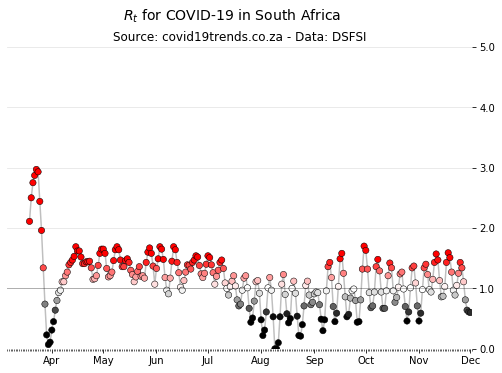

In [118]:
country = states_all_rt_i.filter(like='Total RSA', axis=0)
fig_country, ax = plt.subplots(figsize=(600/72,400/72))
ax = plot_rt(country, ax, state_name = '')
ax.set_title(credit, size=12, weight='light')
fig_country.suptitle(f'$R_t$ for COVID-19 in South Africa', size=14)

In [119]:
states_rt_i = states_all_rt_i.loc[state_filter]

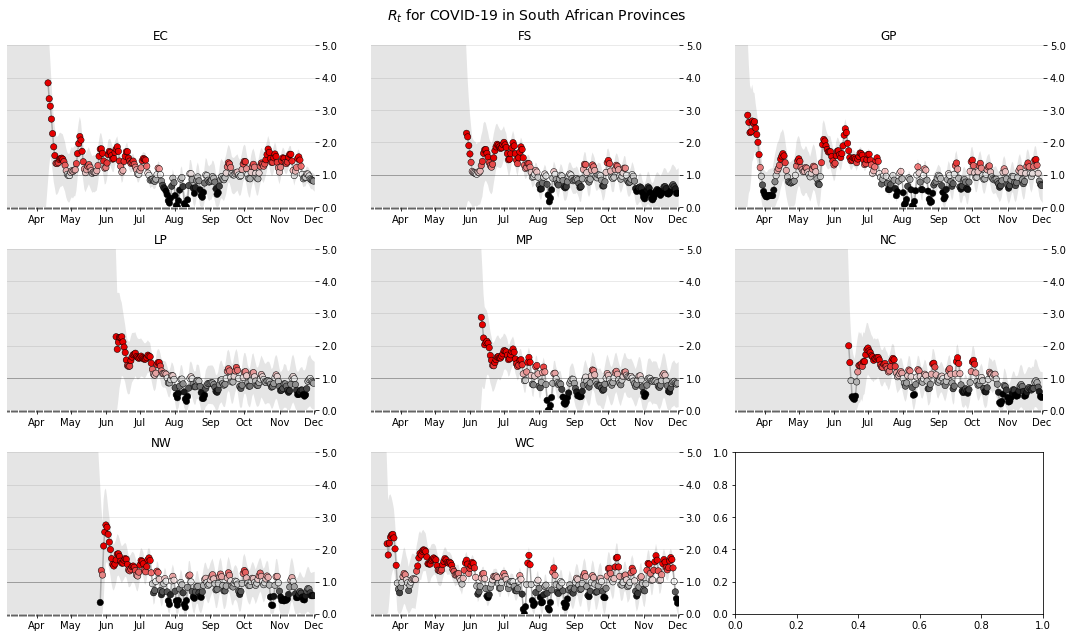

In [120]:
def all_plot(final_results):
    state_groups = final_results.groupby('state')
    
    ncols = 3
    nrows = int(np.ceil(len(state_groups) / ncols))

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*3))

    for i, (state_name, result) in enumerate(state_groups):
        axes.flat[i] = plot_rt(result, axes.flat[i], state_name)

    fig.tight_layout()
    fig.set_facecolor('w')
    
    fig.suptitle(f'$R_t$ for COVID-19 in South African Provinces', size=14)
    fig.subplots_adjust(top=0.92)
    
all_plot(states_rt_i)

## Standings plots

In [121]:
# ZA: South Arica lockdown level data as of 2020/05/03
no_lockdown = [

]
partial_lockdown = [

]
# add items as required -> 'Western Cape','WC',

FULL_COLOR = [.7,.7,.7]
NONE_COLOR = [179/255,35/255,14/255]
PARTIAL_COLOR = [.5,.5,.5]
ERROR_BAR_COLOR = [.3,.3,.3]

In [122]:
# ZA: df slighty different to US
mr = states_all_rt_i.groupby(level=0)[['ML', 'High_90', 'Low_90']].last()
mr

ML  High_90  Low_90
state                           
EC         0.80     1.04    0.51
FS         0.43     1.17    0.00
GP         0.66     1.07    0.17
LP         0.84     1.53    0.03
MP         0.84     1.47    0.09
NC         0.40     1.19    0.00
NW         0.56     1.29    0.00
Total RSA  0.60     0.00    0.00
WC         0.33     0.59    0.02

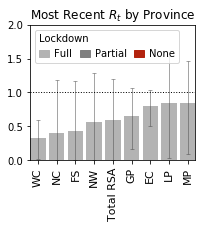

In [123]:
def plot_standings(mr, figsize=None, title='Most Recent $R_t$ by Province'):
    if not figsize:
        figsize = ((15.9/50)*len(mr)+.1,2.5)
        
    fig, ax = plt.subplots(figsize=figsize)

    ax.set_title(title)
    err = mr[['Low_90', 'High_90']].sub(mr['ML'], axis=0).abs()
    bars = ax.bar(mr.index,
                  mr['ML'],
                  width=.825,
                  color=FULL_COLOR,
                  ecolor=ERROR_BAR_COLOR,
                  capsize=2,
                  error_kw={'alpha':.5, 'lw':1},
                  yerr=err.values.T)

    for bar, state_name in zip(bars, mr.index):
        if state_name in no_lockdown:
            bar.set_color(NONE_COLOR)
        if state_name in partial_lockdown:
            bar.set_color(PARTIAL_COLOR)

    labels = mr.index.to_series().replace({'District of Columbia':'DC'})
    ax.set_xticklabels(labels, rotation=90, fontsize=11)
    ax.margins(0)
    ax.set_ylim(0,2.)
    ax.axhline(1.0, linestyle=':', color='k', lw=1)

    leg = ax.legend(handles=[
                        Patch(label='Full', color=FULL_COLOR),
                        Patch(label='Partial', color=PARTIAL_COLOR),
                        Patch(label='None', color=NONE_COLOR)
                    ],
                    title='Lockdown',
                    ncol=3,
                    loc='upper left',
                    columnspacing=.75,
                    handletextpad=.5,
                    handlelength=1)

    leg._legend_box.align = "left"
    fig.set_facecolor('w')
    return fig, ax

mr.sort_values('ML', inplace=True)
plot_standings(mr);

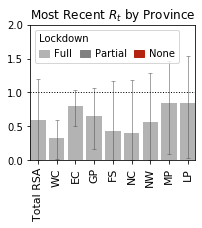

In [124]:
mr.sort_values('High_90', inplace=True)
plot_standings(mr);

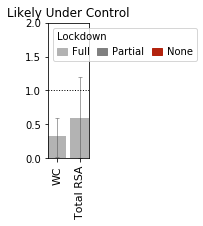

In [125]:
show = mr[mr.High_90.le(1)].sort_values('ML')
fig, ax = plot_standings(show, title='Likely Under Control');

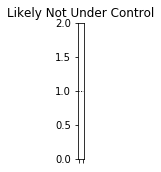

In [126]:
show = mr[mr.Low_90.ge(1.0)].sort_values('Low_90')
fig, ax = plot_standings(show, title='Likely Not Under Control');
ax.get_legend().remove()